# ADA Project : Milestone 2  

## Let's make it Pope-litical!

At first glance, one might think that the Pope does not have much impact on our everyday life and on our country’s politics, yet he influences over 1.3 billion Catholics worldwide and regularly meets with the most powerful political figures of the planet. In the present work, we want to investigate how one of the mightiest apolitical figures on Earth influences one sixth of the world population by using a novel quotations corpus : Quotebank. The main idea is therefore to try to situate the Pope on a political spectrum, here the American political system, using characteristics extracted from the corpus of his quotes. This will help us determine whether such an influential and, suposedly, non-political figure can be aligned with a certain political party or not.

#### Useful libraries

In [1]:
# Utilitaries
import pandas as pd
import bz2
import json
import re
import pickle
import string

# Math
import math
import statistics as stat
import numpy as np
import scipy

#Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# External libraries needed for the project:

#!pip install langdetect
#pip install -U spacy
#pip install empath
#python -m spacy download en_core_web_sm

# Natural language processing libraries
from langdetect import detect # for quotes language filtering
import nltk, spacy, sklearn
from spacy.lang.en import English
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Analysis of the lexical fields
from empath import Empath 

# PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
lemmatizer = nltk.stem.WordNetLemmatizer()
tokenizer = TweetTokenizer()
lexicon = Empath()

## Data importation

We started by extracting the quotation corpus of the Pope and of a few politicians from the Quotebank dataset using our Google Collab file "Import_Quotebank_Colab.ipynb". We end up with much smaller datasets containing between 10'000 and 100'000 quotes which are much easier to manipulate. From those smaller JSON files, we then decided to build individual pandas dataframes  using the function `build_dataframe`, and saved them in the pickle format for an optimized utilization. The advantage of keeping one file per speaker is the small size of the files (between 10 and 20 Mo) that allows us to import them on our git repository. Our function `import_dataframe` simply allows to open one of those pickles files.

In [3]:
def build_dataframe(name_speaker):
    file = '../data/'+ name_speaker +'-quotes.json.bz2'
    output = '../data/'+ name_speaker + '-quotes.pkl'
    data = []
    with bz2.open(file, 'rb') as s_file:
        for instance in s_file:
            
            instance = json.loads(instance)

            row = []
            row.extend([instance['quotation'],instance['speaker'], instance['probas'][0][1]])

            if len(instance['probas']) > 1:       #There are at least 2 speakers
                row.extend([instance['probas'][1][0], instance['probas'][1][1]])
            else:
                row.extend([math.nan, math.nan])

            if len(instance['probas']) > 2:       #There are at least 3 speakers
                row.extend([instance['probas'][2][0], instance['probas'][2][1]])
            else:
                row.extend([math.nan, math.nan])

            row.extend([instance['date'], instance['numOccurrences'], instance['phase'], instance['nbr_words'], len(instance['quotation']), len(instance['probas'])])

            data.append(row)

    df = pd.DataFrame(data, columns =['quote', 'speaker', 'probability', 'second_speaker', 'second_probability', 'third_speaker', 'third_probability', 'date', 'nbr_occurences', 'phase', 'nbr_words', 'nbr_characters', 'nbr_speakers'])
    df.to_pickle(output)
    
def import_dataframe(name_speaker):
    
    file = '../data/'+ name_speaker +'-quotes.pkl'
    return pd.read_pickle(file)

For the rest of our analysis, we work with a unique dataframe containing the data of the 7 speakers of interest. We will perform the same pre-processing steps on all of the quotes.

In [4]:
names = ['Pope','Mike_Pence','Mitt_Romney','Hillary_Clinton','Bernie_Sanders','Elizabeth_Warren','Ted_Cruz']
df = pd.DataFrame()

for s in names:
    # uncomment next line if you need to generate the pickle files
    build_dataframe(s) 
    
    temp = import_dataframe(s)
    df = df.append(temp, ignore_index=True)

In [5]:
df.head(5)

,quote,speaker,probability,second_speaker,second_probability,third_speaker,third_probability,date,nbr_occurences,phase,nbr_words,nbr_characters,nbr_speakers
0,"a good father knows how to wait, and knows how...",Pope Francis,0.7727,None,0.2215,Thomas Rosica,0.0058,2015-02-06 15:31:07,2,E,18,87,3
1,"I don't have an ear for it,",Pope Francis,0.7834,None,0.1408,Mark Miles,0.0758,2015-09-25 01:44:00,1,E,8,27,3
2,Ask `What does this say to my heart? What is G...,Pope Francis,0.9272,None,0.0728,NaN,NaN,2015-12-03 21:20:49,1,E,17,82,2
3,"Be praised, my Lord, through our sister Mother...",Pope Francis,0.7581,None,0.2419,NaN,NaN,2015-06-19 00:49:49,1,E,24,137,2
4,But he's already taken a number of important s...,Pope Francis,0.5039,None,0.4961,NaN,NaN,2015-07-28 19:34:53,2,E,20,103,2


Dataframe variables before pre_processing

`quote`: whole quote as it was extracted online

`speaker`: person most likely to have said `quote`, attributed by QuoBERT

`probability`: probability that the speaker said `quote`, attributed by QuoBERT
 
`second_speaker`: Second most probable person to say `quote` (can be None)

`second_probability`: probability that the second speaker said `quote`, attributed by QuoBERT

`third_speaker`: Third most probable person to say `quote` (can be None)

`third_probability`: probability that the third speaker said `quote`, attributed by QuoBERT

`date`: Exact date and time the article containing  `quote` was published

`nbr_occurences`: Number of different sources that published the `quote`

`phase`: phase of the `quote`

`nbr_words`: number of words in `quote`

`nbr_characters`: number of characters in `quote`

`nbr_speakers`: Number of possible speakers for `quote` (max 3)

#### Change the type of probability variable:
The probabilities are initially of type string. Thus, to facilitate our future analysis, we change them to float numbers:

In [6]:
new_df = df.copy()
new_df = new_df.astype({'probability': 'float64', 'second_probability': 'float64', 'third_probability': 'float64'})

## First glance at the data

#### Number of words per quote:

First, we plot the distribution of the number of words per quote for each speaker.

In [7]:
speakers = ['Pope Francis','Mike Pence','Mitt Romney','Hillary Clinton','Bernie Sanders','Elizabeth Warren','Ted Cruz']

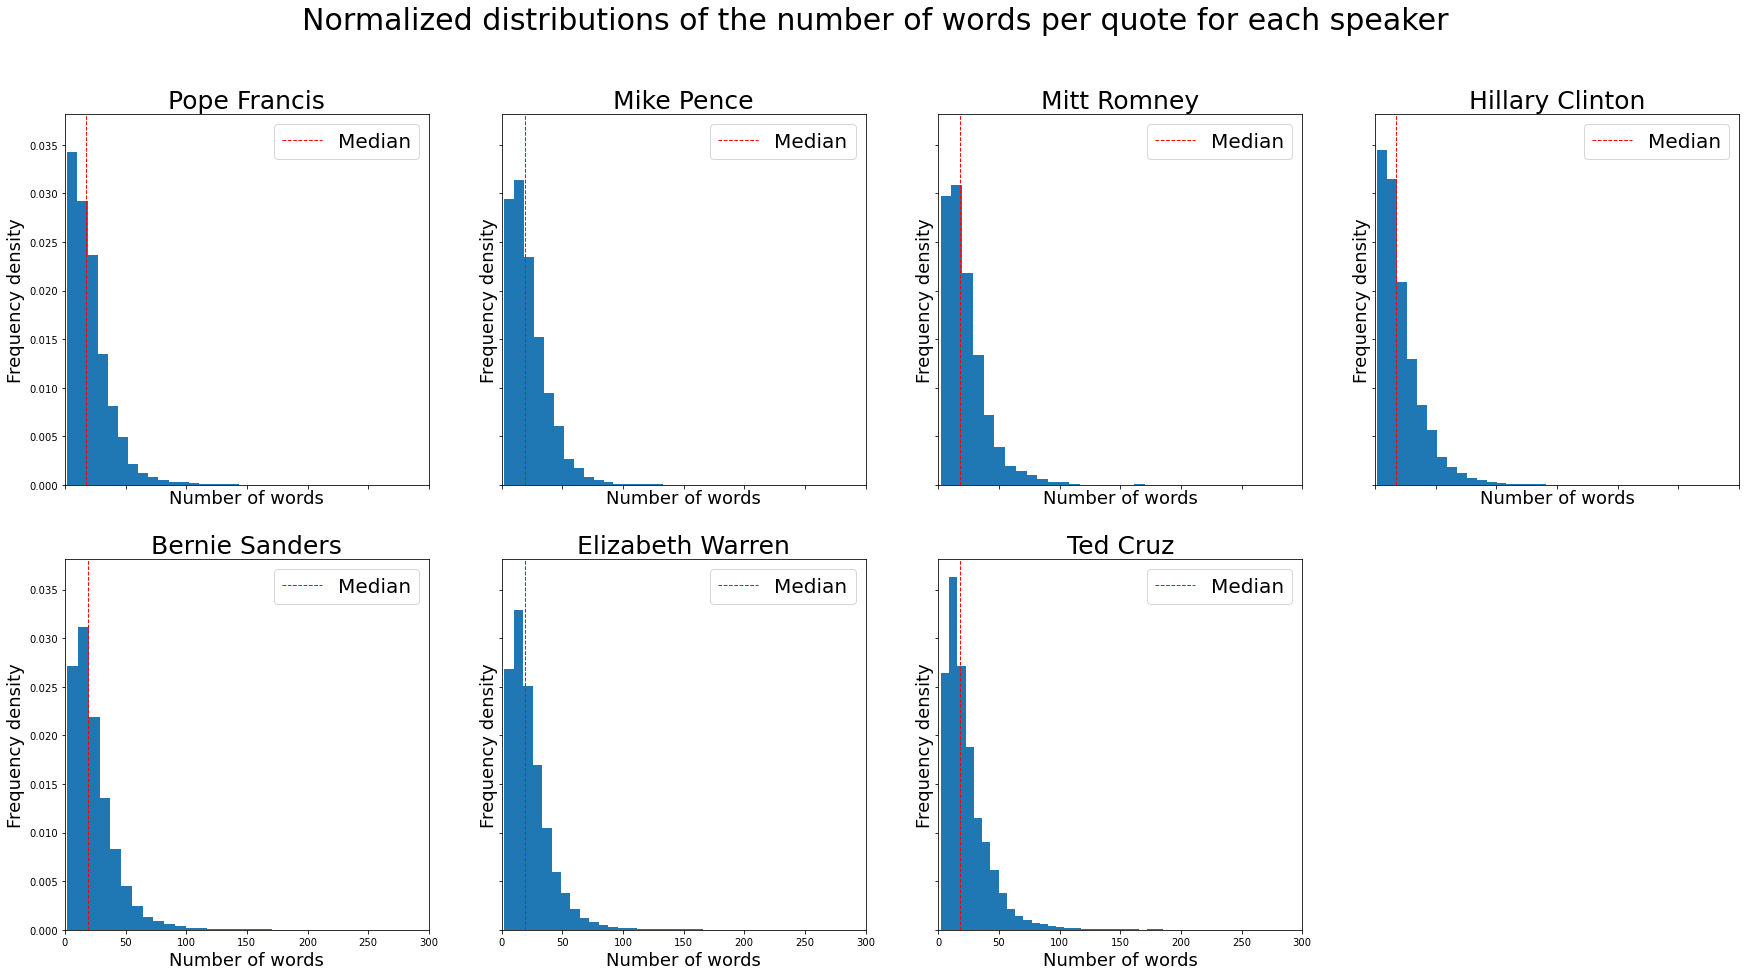

In [8]:
fig, axs = plt.subplots(2,4, figsize=(30, 15), sharex=True, sharey=True)
fig.suptitle('Normalized distributions of the number of words per quote for each speaker', size = 30)

axs = axs.ravel()

for i in range(7):
    data = new_df[new_df.speaker == speakers[i]].nbr_words
    med = data.median()
    axs[i].set_xlim((0,300))
    axs[i].hist(data, density = True, bins = 50)
    axs[i].axvline(x = med, color = 'r', linestyle = 'dashed', linewidth = 1, label='Median')
    axs[i].legend(loc='upper right',prop={'size': 20})
    axs[i].set_title(speakers[i], size = 25)
    axs[i].yaxis.label.set_size(18)
    axs[i].xaxis.label.set_size(18)
    
for ax in axs.flat:
    ax.set(xlabel='Number of words', ylabel='Frequency density')
    
    
fig.delaxes(axs[-1])

The distributions of the number of words per quote are similar across speakers. As the distributions are power law-like, the median will be a much better descriptive statistic than the mean. 

In [9]:
print("Median of the number of words per quote:")
for i in range(len(speakers)):
    print(speakers[i],":", new_df[new_df.speaker == speakers[i]].nbr_words.median())


Median of the number of words per quote:
Pope Francis : 17.0
Mike Pence : 19.0
Mitt Romney : 18.0
Hillary Clinton : 17.0
Bernie Sanders : 19.0
Elizabeth Warren : 19.0
Ted Cruz : 18.0


#### Probability of the first speaker:

Each quote has a probability assigned by the algorithm that indicates the certainity (or not) it was said by the given speaker. Let's investigate these probabilities.

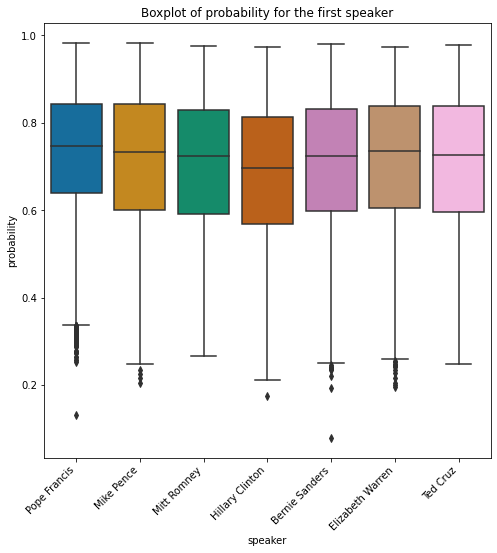

In [10]:
plt.figure(figsize = (8,8))
ax = sns.boxplot(y = 'probability', x = 'speaker', palette = "colorblind", data = new_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha='right')
_ = plt.title("Boxplot of probability for the first speaker")

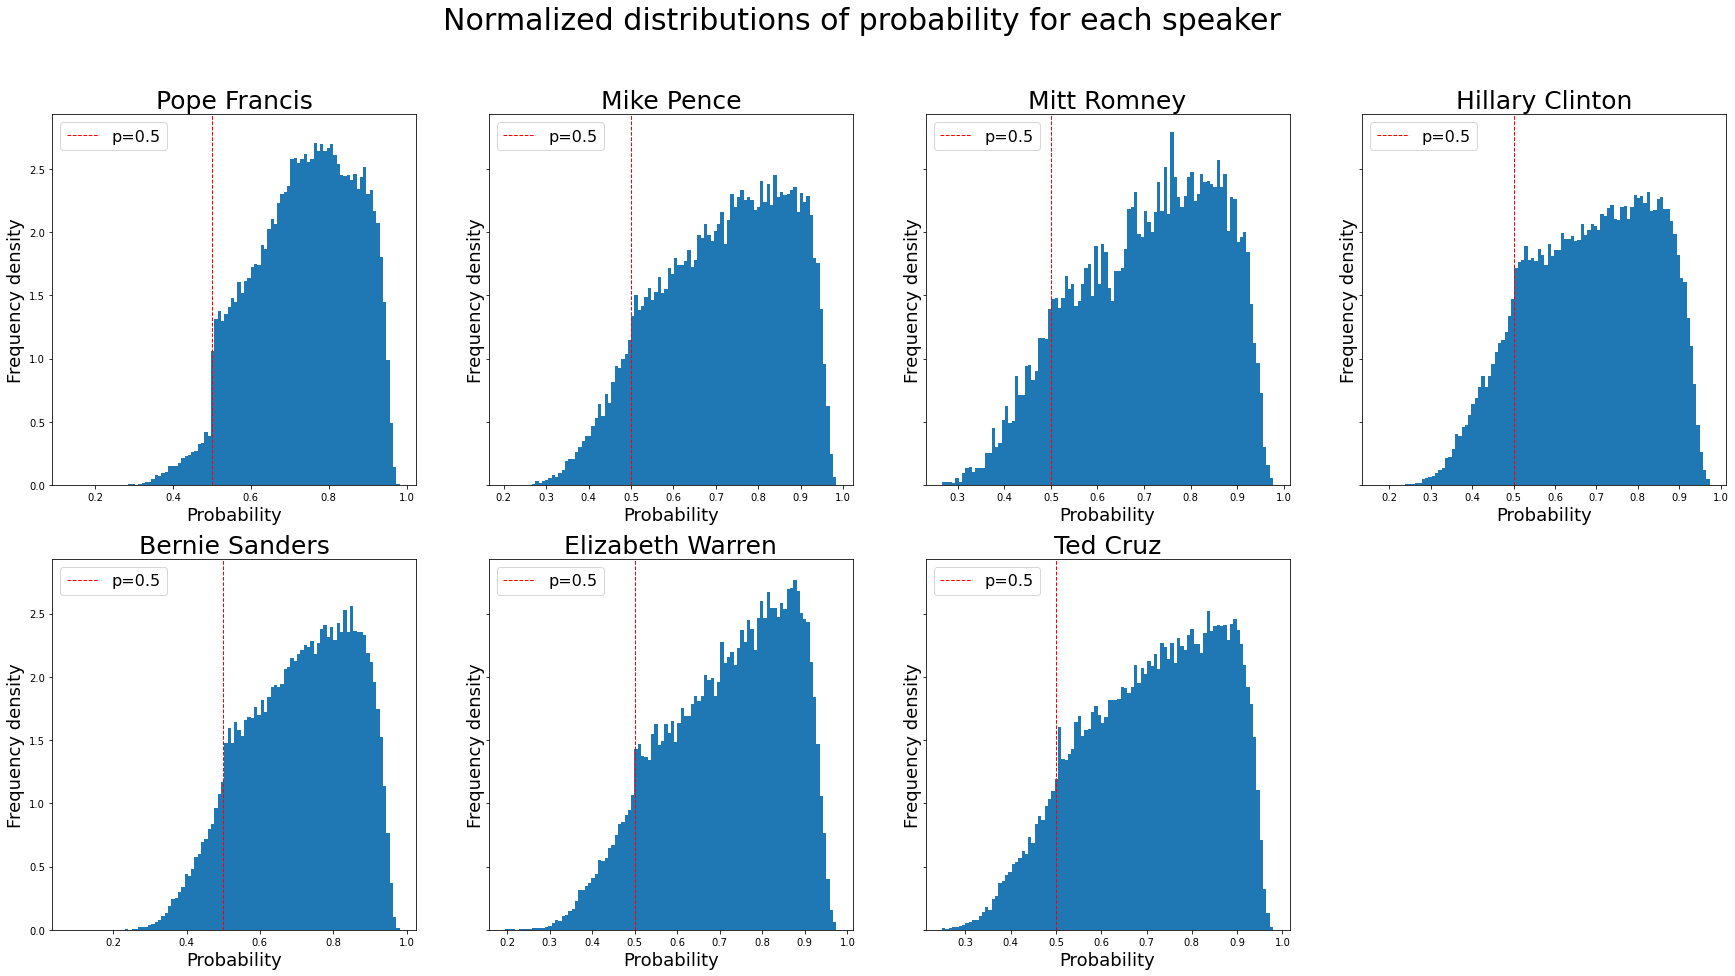

In [11]:
fig, axs = plt.subplots(2,4, figsize=(30, 15), sharey=True)
fig.suptitle('Normalized distributions of probability for each speaker', size = 30)

axs = axs.ravel()

for i in range(len(speakers)):
    data = new_df.loc[new_df.speaker == speakers[i]].probability
    axs[i].hist(data, density = True, bins = 100)
    axs[i].axvline(x = 0.5, color = 'r', linestyle = 'dashed', linewidth = 1,label='p=0.5')
    axs[i].set_title(speakers[i], size = 25)
    axs[i].legend(loc='upper left',prop={'size': 16})
    axs[i].yaxis.label.set_size(18)
    axs[i].xaxis.label.set_size(18)
for ax in axs.flat:
    ax.set(xlabel='Probability', ylabel='Frequency density')
    
fig.delaxes(axs[-1])

Speakers share quite similar distributions in their quote attribution probabilities. Interestingly, for the Pope, the red line threshold at $p = 0.5$ coincides with an abrupt drop of quotes frequency. This drop is not as pronounced for other speakers.

#### Occurence of the quotes:

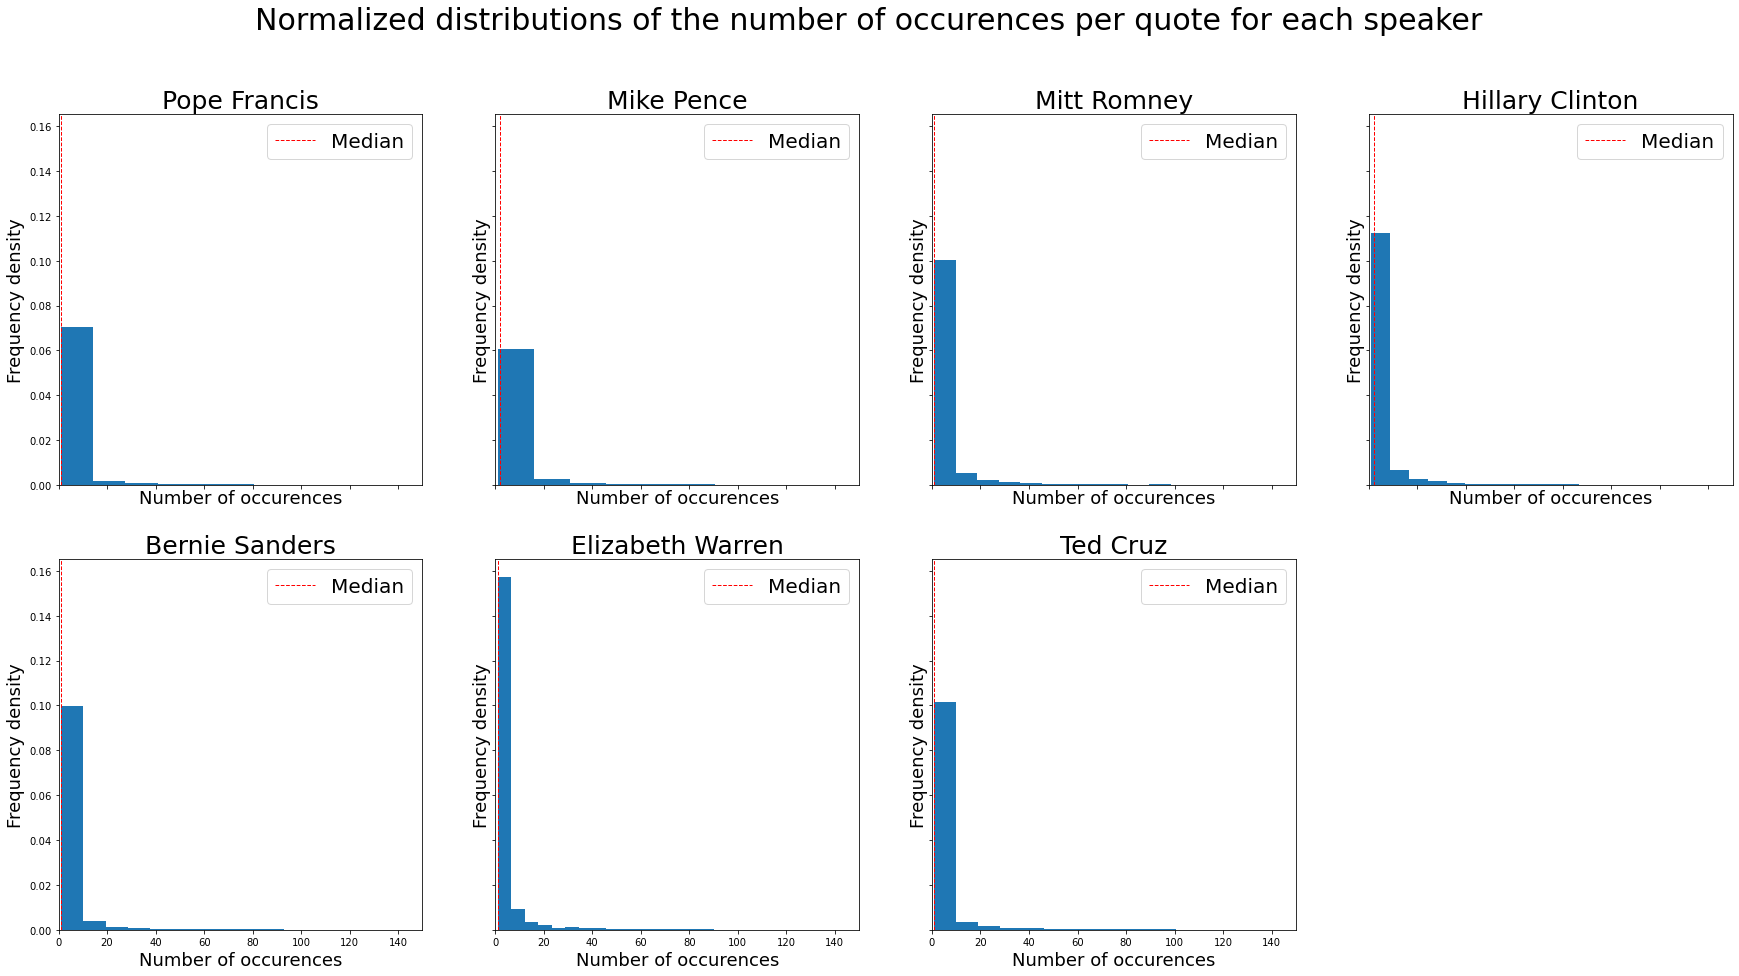

In [12]:
fig, axs = plt.subplots(2,4, figsize=(30, 15), sharex=True, sharey=True)
fig.suptitle('Normalized distributions of the number of occurences per quote for each speaker', size = 30)

axs = axs.ravel()

for i in range(7):
    data = new_df[new_df.speaker == speakers[i]].nbr_occurences
    med = data.median()
    axs[i].set_xlim((0,150))
    axs[i].hist(data, density = True, bins = 200)
    axs[i].axvline(x = med, color = 'r', linestyle = 'dashed', linewidth = 1, label='Median')
    axs[i].legend(loc='upper right',prop={'size': 20})
    axs[i].set_title(speakers[i], size = 25)
    axs[i].yaxis.label.set_size(18)
    axs[i].xaxis.label.set_size(18)
    
for ax in axs.flat:
    ax.set(xlabel='Number of occurences', ylabel='Frequency density')
    
    
fig.delaxes(axs[-1])

In [13]:
print("Median of the number of occurences per quote:")
for i in range(len(speakers)):
    print(speakers[i],":", new_df[new_df.speaker == speakers[i]].nbr_occurences.median())

Median of the number of occurences per quote:
Pope Francis : 1.0
Mike Pence : 2.0
Mitt Romney : 1.0
Hillary Clinton : 2.0
Bernie Sanders : 1.0
Elizabeth Warren : 1.0
Ted Cruz : 1.0


The median of the number of occurences of the quotes is 1 for each speaker. 

## Pre-processing

### Removal of quotes with less than 50% of probability for the first speaker 

A first way to pre-process the quotes is to put a threshold of 50% below which a quote will be removed from the dataset. Indeed, if $p ≥ 0.5$, it means that we are more confident that the speaker of the quote actually said it rather than someone else. As seen previously, only the Pope has a clear drop in quotes frequency for probabilities below 0.5, so we might lose an important number of quotes from the American politicians. Thus, we might have to develop a more robust thresholding criteria in the future. For now, it seems to be the most logical method for a preliminary analysis.

In [14]:
l = len(new_df)
print("Before removing rows with probability <= 0.5: " + str(l) + " quotes")

new_df.drop(new_df.query('probability <= 0.5').index, inplace=True)
new_df = new_df.reset_index(drop=True)

print("After removing rows with probability <= 0.5 : " + str(len(new_df)) + " quotes (" + str(round((l-len(new_df))*100/l,4)) +"% loss)")

Before removing rows with probability <= 0.5: 434711 quotes
After removing rows with probability <= 0.5 : 396655 quotes (8.7543% loss)


### Natural Language pre-processing steps

To handle text properly for natural language processing, a set of classical operations must be performed. We save a new version of the quotes without digits, punctuation, unnecessary spaces and capital letters. 

In [15]:
# remove digits
new_df['pre_processed_quote'] = new_df['quote'].astype(str).str.replace('\d+', '', regex=True)

# remove punctuation
new_df['pre_processed_quote'] = new_df['pre_processed_quote'].apply(lambda x: re.sub(r'[^\w\s]','', x))

# remove spaces at the beginning and ending of quotes
new_df['pre_processed_quote'] = new_df['pre_processed_quote'].str.strip()

# remove capitalization from words
new_df['pre_processed_quote'] = new_df['pre_processed_quote'].str.lower()

Then we remove rows that contain an empty quote or a quote that only contains digits and/or punctuation. For example we found a quote that was written in binary. This step only removes three rows for all our speakers.

In [16]:
l = len(new_df)
print("Before removing aberrant rows : " + str(l) + " quotes")

# remove rows with empty or NaN quotes (so also the ones which only had digits &/or punctuation)
new_df['pre_processed_quote'].replace("", np.nan, inplace=True)
new_df.dropna(subset = ["pre_processed_quote"], inplace=True)

print("After removing aberrant rows : " + str(len(new_df)) + " quotes (" + str(round((l-len(new_df))*100/l,4)) +"% loss)")

Before removing aberrant rows : 396655 quotes
After removing aberrant rows : 396652 quotes (0.0008% loss)


Then, we also tokenize each quote in order to remove stop words (a, and, but, how...). Then the lemmatization is useful for ignoring the variations of words (e.g. plurals and verbs) and concentrate on their meaning. The final preprocessed quotes will be used for lexical fields analysis. 

In [17]:
# Quotes tokenization 
new_df['tokenized_quote'] = new_df['pre_processed_quote'].apply(lambda x: tokenizer.tokenize(x)) 


In [18]:
# removal of stop words (from 2 different lists of stop words)
stop_words = stopwords.words('english')
stop_words.extend(spacy.lang.en.stop_words.STOP_WORDS)

new_df['no_stop_words'] = new_df['tokenized_quote'].apply(lambda x: [word for word in x if not word in stop_words])


Finally, we save a last version of the quotes which consists in the lemmatized version without the stop words.

In [19]:
# Quotes lemmatization on stop words 
new_df['pre_processed_quote'] = new_df['no_stop_words'].apply(lambda x: (" ").join([lemmatizer.lemmatize(w) for w in x]))



In [20]:
new_df.head(5)

,quote,speaker,probability,second_speaker,second_probability,third_speaker,third_probability,date,nbr_occurences,phase,nbr_words,nbr_characters,nbr_speakers,pre_processed_quote,tokenized_quote,no_stop_words
0,"a good father knows how to wait, and knows how...",Pope Francis,0.7727,None,0.2215,Thomas Rosica,0.0058,2015-02-06 15:31:07,2,E,18,87,3,good father know wait know forgive heart,"[a, good, father, knows, how, to, wait, and, k...","[good, father, knows, wait, knows, forgive, he..."
1,"I don't have an ear for it,",Pope Francis,0.7834,None,0.1408,Mark Miles,0.0758,2015-09-25 01:44:00,1,E,8,27,3,dont ear,"[i, dont, have, an, ear, for, it]","[dont, ear]"
2,Ask `What does this say to my heart? What is G...,Pope Francis,0.9272,None,0.0728,NaN,NaN,2015-12-03 21:20:49,1,E,17,82,2,ask heart god saying word,"[ask, what, does, this, say, to, my, heart, wh...","[ask, heart, god, saying, words]"
3,"Be praised, my Lord, through our sister Mother...",Pope Francis,0.7581,None,0.2419,NaN,NaN,2015-06-19 00:49:49,1,E,24,137,2,praised lord sister mother earth feed rule pra...,"[be, praised, my, lord, through, our, sister, ...","[praised, lord, sister, mother, earth, feeds, ..."
4,But he's already taken a number of important s...,Pope Francis,0.5039,None,0.4961,NaN,NaN,2015-07-28 19:34:53,2,E,20,103,2,he taken number important step think pave way ...,"[but, hes, already, taken, a, number, of, impo...","[hes, taken, number, important, steps, think, ..."


### Non-english quotes removal

The Quotebank corpus is mainly composed of quotes in the English language. However, we did notice that a few quotes in other languages managed to find their way in the dataset. To perform efficient natural language processing, we decided to remove every quote that isn't considered as english. This task will be done with the NLP language detection library _langdetect_ that supports over 55 different languages. Many other libraries are available online, but this one is often recommended and supports more languages than most of the other libraries. 

We verify the regularity of the _langdetect_ library by running the algorithm 5 times over the same subset of quotes (the first 5000 ones). We expect a low variation in the number of non-english quotes that are detected.

In [21]:
non_english_quotes = []

extract = new_df['quote'][0:5000] # Small extract to test detect() from langdetect

for i in range(5):
    count = 0
    for n, quote_ in enumerate(extract) :
        value = detect(quote_)
        if value != "en":
            count += 1
        
    non_english_quotes.append(100*count/len(extract))
        
print("Percentage of non-english quotes recognized by langdetect (mean ± SD) on the same subset of 5000 quotes: ", np.mean(non_english_quotes), " ± ", round(np.std(non_english_quotes),3))

Percentage of non-english quotes recognized by langdetect (mean ± SD) on the same subset of 5000 quotes:  1.092  ±  0.037


We observe that the detection seems regular, which confort us in using this library for our large dataset.

In [22]:
new_df = new_df.reset_index(drop=True)
index = []

l = len(new_df)
print("Before removing non-english quotes : " + str(l) + " quotes")

# This section takes more than 30min to run
for n, quote_ in enumerate(new_df['quote']) :
    value = detect(quote_)
    if value != "en":
        index.append(n)
        
new_df.drop(index, inplace=True)
new_df = new_df.reset_index(drop=True)

print("After removing non-english quotes : " + str(len(new_df)) + " quotes (" + str(round((l-len(new_df))*100/l,4)) +"% loss)")

Before removing non-english quotes : 396652 quotes
After removing non-english quotes : 391558 quotes (1.2842% loss)


In summary, our whole pre-processing procedure ended up removing only a small percentage of the quotations.

In [23]:
print("Total percentage of quotes removed : " + str(round((len(df)-len(new_df))*100/len(df),4)) +"% (" + str(len(df)-len(new_df)) + " quotes)")

Total percentage of quotes removed : 9.9268% (43153 quotes)


We save the pre-processed version of our dataframe for further analysis

In [24]:
new_df.to_pickle("../data/pre_processed_df.pkl")

## Feature extraction

In this section, we extract the following features on the quotes of each speaker:
* the median of the number of words in the quotes
* the median of the number of characters in the quotes
* the median of the number of occurences in the quotes
* the richness of the vocabulary, that we compute by counting the number of different words in the pre-processed quotes and by dividing it by the total number of quotes of the speaker.
* The scores returned by the analyze function of the Empath library for different lexical categories. We choose these categories to cover a wide range of lexical fields and obtain a score for each one of them. The whole list of categories of this library can be found following this link https://github.com/Ejhfast/empath-client/blob/master/empath/data/categories.tsv

In [56]:
def extract_features(df):
    # Median of the number of words, characters and occurences in the quotes
    features_nbr_words = pd.DataFrame(data = {'median_nbr_words': df['nbr_words'].median()}, index=[0])
    features_nbr_chars = pd.DataFrame({'median_nbr_characters': df['nbr_characters'].median()}, index=[0])
    features_nbr_occurences = pd.DataFrame({'median_nbr_occurences': df['nbr_occurences'].median()}, index=[0])

    #Feature 'vocabulary richness'
    all_words = pd.DataFrame(df['tokenized_quote'].explode(ignore_index=True)).rename({'tokenized_quote': 'word'}, axis=1)
    unique_words = all_words.value_counts().rename_axis('word').reset_index(name='nbr_occurence')
    feature_voc = pd.DataFrame({'voc_richness': len(unique_words)/len(df)}, index=[0])

    #Features 'lexical fields'
    features_lex_fields = pd.DataFrame([lexicon.analyze(df['pre_processed_quote'].str.cat(sep = ' '), categories = ["money","hate","family","health","dispute","nervousness","government",
                                                          "swearing_terms","suffering","optimism","divine","sexual","fear","business","religion",
                                                         "worship","leader","death","violence","military","war","rage","science","sadness",
                                                         "joy","economics","politics","anger","strength","power","terrorism","poor","pain",
                                                         "philosophy","negative_emotion","competing","law","achievement","contentment",
                                                         "positive_emotion"])])

    features = pd.concat([features_nbr_words, features_nbr_chars, features_nbr_occurences, feature_voc, features_lex_fields, pd.DataFrame([s[1]], columns=["party"])], axis=1)    
    
    return features


Speakers are assigned a label based on their political party: 0 = apolitical (Pope), 1 = Democrats, 2 = Republicans

In [57]:
# We extract the features for each speaker

# To use directly the pre-processed file, uncomment this section:
#file = '../data/'+ 'pre_processed_df.pkl'
#new_df = pd.read_pickle(file)

speakers = [['Pope Francis',0],['Hillary Clinton',1],['Bernie Sanders',1],['Elizabeth Warren',1],['Mike Pence',2],['Mitt Romney',2],['Ted Cruz',2]]

all_features = pd.DataFrame()

for s in speakers:
    
    new_features = extract_features(new_df[new_df['speaker'].str.match(s[0])])
    
    all_features = all_features.append(new_features)
    all_features.rename(index={0: s[0]}, inplace=True)

all_features.to_pickle("../data/all_features.pkl")
all_features


,median_nbr_words,median_nbr_characters,median_nbr_occurences,voc_richness,money,hate,family,health,dispute,nervousness,...,poor,pain,philosophy,negative_emotion,competing,law,achievement,contentment,positive_emotion,party
Pope Francis,18.0,99.0,1.0,0.271167,5690.0,7071.0,24700.0,6134.0,8763.0,5092.0,...,9841.0,12239.0,9701.0,18266.0,4325.0,10808.0,8995.0,7404.0,37678.0,0
Hillary Clinton,18.0,96.0,1.0,0.333223,13935.0,5084.0,10273.0,4624.0,13956.0,3371.0,...,7887.0,5022.0,4857.0,17587.0,9896.0,16658.0,10760.0,2021.0,16290.0,1
Bernie Sanders,19.0,106.0,1.0,0.290860,26447.0,4611.0,7527.0,8296.0,15523.0,2211.0,...,13250.0,4306.0,9241.0,19325.0,11614.0,23015.0,11094.0,1295.0,14844.0,1
Elizabeth Warren,19.0,105.0,1.0,0.455627,18116.0,2188.0,6480.0,3870.0,9853.0,1190.0,...,6371.0,2183.0,2959.0,12831.0,6902.0,15914.0,5218.0,614.0,9014.0,1
Mike Pence,19.0,107.0,1.0,0.452471,5513.0,1218.0,4889.0,2773.0,7688.0,642.0,...,3541.0,1501.0,3326.0,4896.0,3871.0,11495.0,6672.0,761.0,10897.0,2
Mitt Romney,19.0,101.0,1.0,1.033862,1432.0,553.0,974.0,462.0,1858.0,278.0,...,908.0,521.0,561.0,1761.0,1360.0,2626.0,1480.0,208.0,2041.0,2
Ted Cruz,19.0,103.0,1.0,0.494748,7351.0,2861.0,4261.0,1557.0,10331.0,777.0,...,3351.0,2428.0,3374.0,9088.0,6312.0,15928.0,5990.0,722.0,7211.0,2


## PCA

Now that we extracted our features of interest for each speaker's corpus of quotes, we want to apply a dimensionality reduction method in order to summarize those numerous features and to visualize our data into that reduced space. We chose to go for the principal component analysis (PCA) because it allows to decorrelate the features, maximize the variance of the data in the new space while still providing interpretable results as the components are linear combinations of the original features.

In [58]:
#this allows to load the results of the feature extraction
file = '../data/all_features.pkl'
all_features = pd.read_pickle(file)

It's important to normalize (zero mean and unit variance) the features before running the PCA because our different features have very different scales and we don't want the PCA results to be affected by that. We also wanted to make sure that keeping only 2 components do not lead us to loose too much of the original's data information.

The 2D PCA contains 88.9394 % of the information

Component 1 contains 59.26515400188074 % of the information
Component 2 contains 29.674259133509413 % of the information
Component 3 contains 4.86000937303204 % of the information

So far, 6.200577491577808 % of the information has been lost


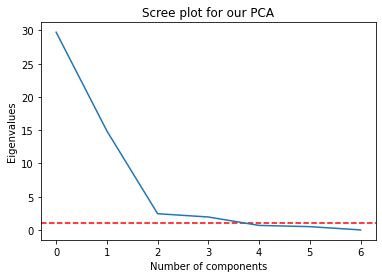

In [59]:
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(all_features.loc[:,:'positive_emotion']), columns = all_features.loc[:,:'positive_emotion'].columns).copy()

%matplotlib inline

pca_screeplot = PCA(n_components=7)
pca_screeplot.fit_transform(scaled_df)
pca = PCA().fit(scaled_df)

# Percentage variance explaines
ratio = pca_screeplot.explained_variance_ratio_
print('The 2D PCA contains',round((ratio[0]+ratio[1])*100,4),'% of the information' )
print("")
print ('Component 1 contains',ratio[0]*100,'% of the information' )
print ('Component 2 contains',ratio[1]*100,'% of the information' )
print ('Component 3 contains',ratio[2]*100,'% of the information' )
print("")
print ('So far,',(1-np.sum([ratio[0],ratio[1],ratio[2]]))*100,'% of the information has been lost' )

#Scree Plot
plt.ylabel("Eigenvalues")
plt.xlabel("Number of components")
plt.title("Scree plot for our PCA")
plt.axhline(y = 1, color = 'r', linestyle = '--')
plt.plot(pca.explained_variance_)
plt.show()


According to the elbow criterion, keeping two components for the PCA makes sense. Moreover, by doing so, we are able to describe more than 80% of the original data variance which is satisfactory.

We also wanted to bring some interpretability to our PCA's results by visualizing which features the principal components are correlated with.

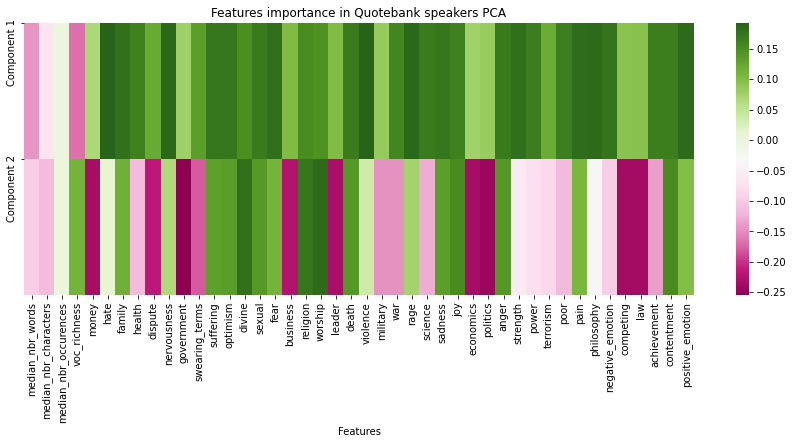

In [60]:
%matplotlib inline

plt.figure(figsize=(15,5))

pca_2d = PCA(n_components=2)
pca_2d.fit_transform(scaled_df)
pca = PCA().fit(scaled_df)

map_ = pd.DataFrame(pca_2d.components_,columns=scaled_df.columns)
sns.heatmap(map_,cmap="PiYG")
plt.title("Features importance in Quotebank speakers PCA")
plt.yticks([0,1],['Component 1','Component 2'], fontsize=10)
plt.xlabel('Features')
plt.show()

From this heatmap, we can see that the first component is more or less positively correlated with all of our lexical fields features and is negatively correlated with the richness of the vocabulary of the speaker. Interestingly, component 2 seems to be negatively correlated with non-human-related lexical fields features (competing, law, economics, politics, leader, business, governement, dispute, money) while being positively correlated with emotions and religious topics (contentment, anger, joy, sadness, death, religion, worship).

In [43]:
#2D PCA
PCA_2d = PCA(n_components=2)
PCs_2 = PCA_2d.fit_transform(scaled_df)
res_PCA_2d = pd.DataFrame(data = PCs_2, columns = ['Principal component 1', 'Principal component 2'])

#3D PCA
PCA_3d = PCA(n_components=3)
PCs_3 = PCA_3d.fit_transform(scaled_df)
res_PCA_3d = pd.DataFrame(data = PCs_3, columns = ['Principal component 1', 'Principal component 2', 'Principal component 3'])


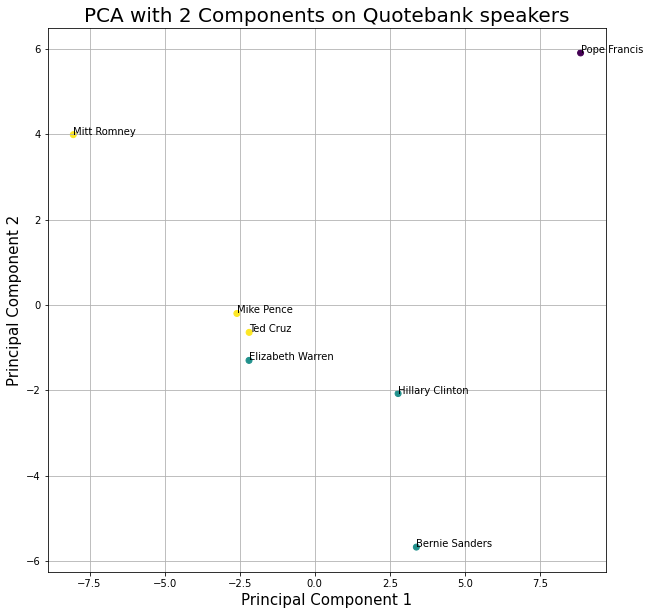

In [44]:
#Visualize results 2D PCA
%matplotlib inline

plt.figure(figsize=(10,10))
plt.xlabel('Principal Component 1',fontsize = 15)  
plt.ylabel('Principal Component 2',fontsize = 15)  
plt.title("PCA with 2 Components on Quotebank speakers",fontsize=20) 

plt.scatter(res_PCA_2d.loc[:,'Principal component 1'], res_PCA_2d.loc[:,'Principal component 2'], c = all_features['party'])

speakers = [['Pope Francis',0],['Hillary Clinton',1],['Bernie Sanders',1],['Elizabeth Warren',1],['Mike Pence',2],['Mitt Romney',2],['Ted Cruz',2]]

for i, speaker in enumerate(speakers):
    plt.annotate(speaker[0], (res_PCA_2d.loc[:,'Principal component 1'][i], res_PCA_2d.loc[:,'Principal component 2'][i]))

plt.grid()
plt.savefig("../data/PCA_visualization.png")
plt.show()

The results of the PCA are interesting for a few reasons:
- The Political parties (yellow and blue) are almost completely separeted from one another
- The pope is completely isolated from the two parties (purple)
- The politicians seem to form a sort of spectrum
- Along component 1 we see that:
    - The pope has by far the less rich vocabulary, this might be due to the fact that he is not a native english speaker and that most of his quotations are translations
    - Republicans seem to have more vocabulary richness than Democrates
- Along component 2 we see that:
    - The pope is really not interested in speaking about law, economics, politics, business, governement and money but is really a big fan of talking about human emotions and religion
    - Democrates seem to be more talking about law, economics, politics, business, governement and money than Republicans are

### Validation of the PCA

To gain confidence in our PCA results, we wanted to perform a cross-validation. To do so, we randomly draw subsamples of quotes for each of our speakers, extract the features for each of those subsamples and run the PCA. In other words, each speaker will not be represented by one single data point but by a small cloud. We expect the clouds to be rather small, even for small subsample sizes.

In [61]:
speakers = [['Pope Francis',0,'mediumblue'],['Hillary Clinton',1,'darkorchid'],['Bernie Sanders',1,'hotpink'],['Elizabeth Warren',1,'cyan'],['Mike Pence',2,'gold'],['Mitt Romney',2,'tomato'],['Ted Cruz',2,'grey']]
validation_df = pd.DataFrame()

nbr_repetitions = 30
size_subsample = 5000

for s in speakers:
    
    #corpus of one speaker
    temp_speaker = new_df[new_df['speaker'].str.match(s[0])]
    
    #we randomly a subsample of the speaker's quotes
    for i in range(nbr_repetitions):
        
        temp_subsample = temp_speaker.sample(n=size_subsample)
        #we extract the features of that subsample
        temp_features = extract_features(temp_subsample)
        temp_features['speaker'] = s[2]
        
        validation_df = validation_df.append(temp_features, ignore_index=True)

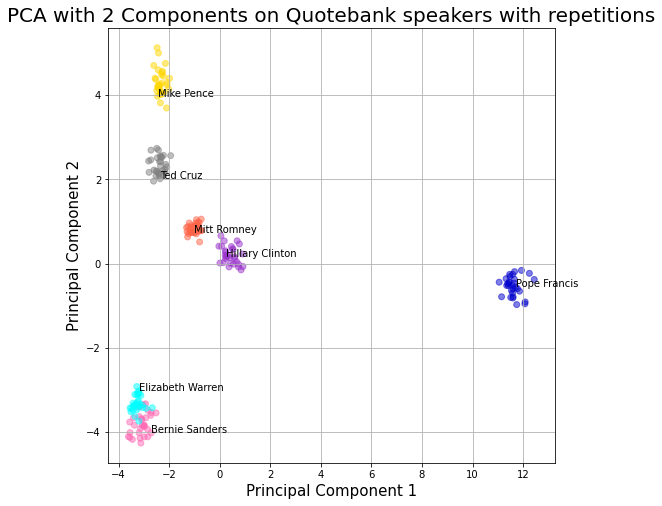

In [62]:
%matplotlib inline

#scaling of the data
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(validation_df.loc[:,:'positive_emotion']), columns = validation_df.loc[:,:'positive_emotion'].columns).copy()

#2D PCA
PCA_2d = PCA(n_components=2)
PCs_2 = PCA_2d.fit_transform(scaled_df)
res_PCA_2d = pd.DataFrame(data = PCs_2, columns = ['Principal component 1', 'Principal component 2'])

#plot the PCA
plt.figure(figsize=(8,8))
plt.xlabel('Principal Component 1',fontsize = 15)  
plt.ylabel('Principal Component 2',fontsize = 15)  
plt.title("PCA with 2 Components on Quotebank speakers with repetitions",fontsize=20) 
plt.scatter(res_PCA_2d.loc[:,'Principal component 1'], res_PCA_2d.loc[:,'Principal component 2'], c = validation_df['speaker'], alpha = 0.5)

#legend of each datapoints cluster
for i, s in enumerate(speakers):
    plt.annotate(s[0], (res_PCA_2d.loc[:,'Principal component 1'][i*nbr_repetitions], res_PCA_2d.loc[:,'Principal component 2'][i*nbr_repetitions]))


plt.grid()
plt.show()

We are satisfied with the size of each speaker's cluster because it shows that even for a small number of quotes, the results of our method are highly reproducible. On the other hand, we are still unsure why the position of each speaker's cloud changed. We will need further analyses to find an explanation.